In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%ls -ltrh /Users/laurentperrinet/quantic/grants/Polychronies/RSG-spikepatterns/Data/

total 2267760
-rw-r--r--  1 laurentperrinet  staff   211M Jun 14 10:42 H_Ready-Set_bin1ms_alignedReady.mat
-rw-r--r--  1 laurentperrinet  staff   407M Jun 14 10:55 G_Ready-Set_bin1ms_alignedReady.mat
-rw-r--r--@ 1 laurentperrinet  staff   2.0K Jun 15 12:29 README.md
-rw-r--r--@ 1 laurentperrinet  staff   183M Jun 27 15:52 G_Ready-Set_bin1ms_alignedReady_session=0.npz
-rw-r--r--@ 1 laurentperrinet  staff   212M Jun 27 15:52 G_Ready-Set_bin1ms_alignedReady_session=1.npz
-rw-r--r--@ 1 laurentperrinet  staff    17M Jun 27 15:52 H_Ready-Set_bin1ms_alignedReady_session=0.npz
-rw-r--r--@ 1 laurentperrinet  staff    68M Jun 27 15:52 H_Ready-Set_bin1ms_alignedReady_session=1.npz


In [3]:
i_session = 0
monkey = 'G'
from pathlib import Path
path = Path.home()/'quantic'/'grants'/'polychronies'/'RSG-spikepatterns'/'Data'/f'{monkey}_Ready-Set_bin1ms_alignedReady_session={i_session}.npz'

dictdata = np.load(path)
data, id_neuron, id_short, t_s, t_p = dictdata['data'], dictdata['id_neuron'], dictdata['id_short'], dictdata['t_s'], dictdata['t_p']
data = data.astype(float)
data[data==255] = np.nan
N_time, N_neuron, N_trial = data.shape

N_time, N_neuron, N_trial

(1200, 107, 1498)

### computing the firing rates

In [4]:
t_s_max = int(t_s.max())
DeltaT = 100 # number of time bins on which we average
dt = 40 # temporal distance between points on which we compute the firing rate

timepoints = np.arange(DeltaT, t_s_max+1, dt)
N_timepoint = len(timepoints)
timepoints, N_timepoint

(array([ 100,  140,  180,  220,  260,  300,  340,  380,  420,  460,  500,
         540,  580,  620,  660,  700,  740,  780,  820,  860,  900,  940,
         980, 1020, 1060, 1100, 1140, 1180]),
 28)

In [5]:
fr = np.empty((N_timepoint, N_neuron, N_trial)) * np.nan
for i_timepoint, timepoint in enumerate(timepoints):
    fr[i_timepoint, :, :] = np.nansum(data[(timepoint-DeltaT):timepoint, :, :], axis=0) / (DeltaT/1000)

In [6]:
fr.shape

(28, 107, 1498)

In [7]:
ratio_train = 80/100
N_trial_train = int(N_trial*ratio_train)
N_trial_test = N_trial - N_trial_train
idx_trial = np.random.permutation(N_trial)
idx_trial

array([934, 157, 392, ..., 826, 542, 868])

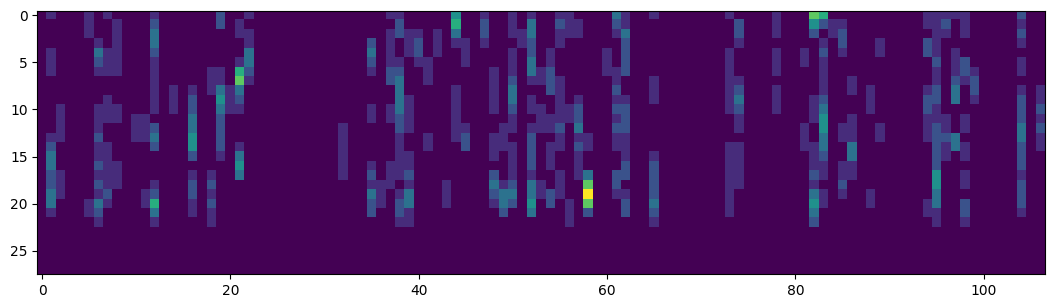

In [8]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(fr[:, :, 102], cmap='viridis')

### logistic regression model with NaNs

### inference model

In [9]:
import torch
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = 'cpu'

device = 'cpu'

In [10]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_dtype(torch.float64) # -> torch.tensor([1.2, 3]).dtype = torch.float64
criterion = torch.nn.BCELoss(reduction="mean") 

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, N_neuron, N_timepoint, logit_0=-2., logit_wt=0.1):
        super(LogisticRegressionModel, self).__init__() 
        self.bias = torch.nn.Parameter(logit_0*torch.ones(1, N_timepoint))
        self.weight = torch.nn.Parameter(logit_wt * torch.randn((N_neuron, N_timepoint)))

    def forward(self, X_input):
        # X_input.shape = N_batch, N_neuron
        X_input[torch.isnan(X_input)] = 0.
        return F.softmax(torch.tensordot(X_input, self.weight, dims=1) +  self.bias, dim=1)

In [11]:
learning_rate = 1.e-05
logit_0 = -2.
logit_wt = 0.01
beta1, beta2 = 0.995, 0.999
num_epochs = 2 ** 10 + 1
amsgrad = True  # gives similar results
amsgrad = False # gives similar results

In [12]:

def fit_data(fr, logit_0=logit_0, logit_wt=logit_wt,
                learning_rate=learning_rate,
                num_epochs=num_epochs,
                beta1=beta1, beta2=beta2, amsgrad=amsgrad,
                verbose=False, 
        ):

    logistic_model = LogisticRegressionModel(N_neuron, N_timepoint, logit_0=logit_0, logit_wt=logit_wt)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=(beta1, beta2), amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for i_trial in idx_trial[range(N_trial_train)]:
            X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
            time_labels = np.arange(N_timepoint)[X.sum(axis=1)>0]
            X = X[time_labels, :]
            labels = F.one_hot(torch.tensor(time_labels), num_classes=N_timepoint)*1.
            X, labels = X.to(device), labels.to(device)
            outputs = logistic_model(X)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    return logistic_model, np.mean(losses)


In [13]:
logistic_model, loss = fit_data(fr, verbose=True)

Iteration: 0 - Loss: 0.15965
Iteration: 32 - Loss: 0.13099
Iteration: 64 - Loss: 0.13015
Iteration: 96 - Loss: 0.12997
Iteration: 128 - Loss: 0.12989
Iteration: 160 - Loss: 0.12984
Iteration: 192 - Loss: 0.12980
Iteration: 224 - Loss: 0.12977
Iteration: 256 - Loss: 0.12974
Iteration: 288 - Loss: 0.12971
Iteration: 320 - Loss: 0.12969
Iteration: 352 - Loss: 0.12967
Iteration: 384 - Loss: 0.12965
Iteration: 416 - Loss: 0.12963
Iteration: 448 - Loss: 0.12961
Iteration: 480 - Loss: 0.12959
Iteration: 512 - Loss: 0.12957
Iteration: 544 - Loss: 0.12956
Iteration: 576 - Loss: 0.12954
Iteration: 608 - Loss: 0.12953
Iteration: 640 - Loss: 0.12951


In [ ]:
with torch.no_grad():
    counts = np.zeros((N_timepoint, N_timepoint))
    outputs = np.zeros((N_timepoint, N_timepoint))
    for i_trial in idx_trial[range(N_trial_train, N_trial)]:
        X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
        time_labels = np.arange(N_timepoint)[X.sum(axis=1)>0]
        counts[time_labels, :] += 1
        X = X[time_labels, :]
        output = logistic_model(X).numpy()
        outputs[time_labels, :] += output

    outputs = outputs/counts

outputs.shape, counts.shape, outputs.sum(axis=1)

In [ ]:
outputs.min(), outputs.max()

In [ ]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(outputs, cmap='viridis')
ax.set_xlabel('predicted time')
ax.set_ylabel('true time')

## scan parameters

In [ ]:
N_scan = 5
for learning_rate_ in learning_rate*np.logspace(-1, 1, N_scan, base=10):
    logistic_model, loss = fit_data(fr, learning_rate=learning_rate_, verbose=False)
    print(f'learning_rate={learning_rate_:.3e}:{loss=:.3e}')

In [ ]:
for logit_0_ in logit_0*np.logspace(-1, 1, N_scan, base=10):
    logistic_model, loss = fit_data(fr, logit_0=logit_0_, verbose=False)
    print(f'logit_0={logit_0_:.3e}:{loss=:.3e}')

In [ ]:
for logit_wt_ in logit_wt*np.logspace(-1, 1, N_scan, base=10):
    logistic_model, loss = fit_data(fr, logit_wt=logit_wt_, verbose=False)
    print(f'logit_wt={logit_wt_:.3e}:{loss=:.3e}')

In [ ]:
for beta1_ in 1-np.logspace(-2, -5, N_scan, base=10):
    logistic_model, loss = fit_data(fr, beta1=beta1_, verbose=False)
    print(f'beta1={beta1_:.3e}:{loss=:.3e}')

In [ ]:
for beta2_ in 1-np.logspace(-1, -4, N_scan, base=10):
    logistic_model, loss = fit_data(fr, beta2=beta2_, verbose=False)
    print(f'beta2={beta2_:.3e}:{loss=:.3e}')

In [ ]:
logistic_model, loss = fit_data(fr, amsgrad=not(amsgrad), verbose=False)
print(f'amsgrad={not(amsgrad)}:{loss=:.3e}')